# Objectives:

<del>1.Read particle file Current Weighting and X-Y location at the highest magnitude Z-location

<del>2.Read particle file Power Weighting and X-Y location at the highest magnitude Z-location

<del>3.Plot 2-D intensity of current or power as a function of X or Y at a line intersection or region of interest (slices of the beam shape).

<del>4.Plot 3-D density of current or power vs X/Y (The whole of the beam shape)

5.User interface: Scale the axes appropriately (what does that mean?) <b>Currently set to a meaningful measurement of centimeters. The frequencies must be properly analyzed for meaningfulness. </b>

6.We needs ability to adjust the scaling of each axis (X/Y/Current/Power)
<b>Simple enough, we just need to multiply by some constant as the data is entered and ensure all labels are consistent.</b>

7.We need the ability to use the bin “area size” to calculate density plots of power and current. <b>Binnings are calculated, 2D/3D gaussian representations are plotted, and KDE plots are made for 1-D case X-,Y-directions.</b>

8.Hence we need to have a good bin size automation tool based on the total number of Z-intersecting particles, the total area, and the error variable. <b>Again, binnings must be based on physical reality to obtain meaningful and universal measurements. length scale ~ centimeter (10^-3) at least. Beyond that, we run the risk of overanalyzing noise patterns and losing overall valuable information.</b>

9.User interface: X and Y to be in user selected measure of length (inches and meters)

10.User interface: Algorithms for Gaussian and “Top Hat” shapes, and FFT analysis as a stretch goal

11.User interface: Able to modify the algorithm variables and coefficients

12.Save images

13.Save bin files

14.Document script

In [1]:
import physt
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

from   scipy       import stats
from   scipy.stats import kde
from   matplotlib  import colors
from   physt       import h1, h2, histogramdd

In [2]:
%matplotlib inline

#### Needs to account for:
(1) # particles used which strike the target anode, \
(2) cross sectional area containing particles which strike target anode, \
(3) random effects on statistical error.

In [3]:
x_in      = [] # particle x-position in [inches].
y_in      = [] # particle y-position.
z_in      = [] # particle z-position.

p_I       = [] # particle current    in [Amperes].
p_KP      = [] # particle power      in [Watts].

In [4]:
file_name = 'quick_input.out'

## Import some data set values

In [5]:
with open(file_name) as file:
    data = pd.read_csv(file, delimiter='\t', header=2, skipfooter=1, engine='python')
    
    x_in  = data['x[in]'] * 2.54 # converts inches to centimeters.
    y_in  = data['y[in]'] * 2.54
    z_in  = data['z[in]'] * 2.54
    p_I   = data['pI[A]']
    p_KP = data['pKP[W]']

# Let's exclude data points which never reach the target!
z_target = z_in.max() # We find the maximum of our z_in data set: assume target z-value.
invalids = []
for i,z in enumerate(z_in):
    if z != z_target:
        invalids.append(i)  # Obtain indices of z-coords which do not equal target's.
        
# Remove data points for these particles which "miss".
x_in = np.delete(np.array(x_in),invalids)
y_in = np.delete(np.array(y_in),invalids)
z_in = np.delete(np.array(z_in),invalids)
p_I  = np.delete(np.array(p_I), invalids)
p_KP = np.delete(np.array(p_KP),invalids)

#### Can easily switch between p_KP and p_I for power and current weighting, respectively.

In [6]:
weighting = p_KP # We can easily switch global weights for either current or power.

In [7]:
dl = 1e-3 # cm*1e-3 = decimilimeters = 1e-5 meters.
m  = 0    # Some integer to offset borders and get better view.

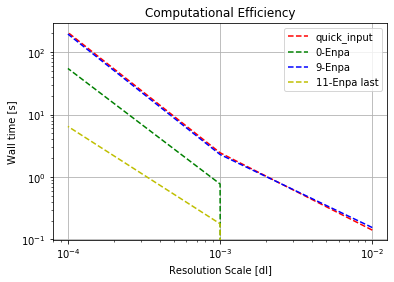

In [8]:
res               = [1e-2,1e-3,1e-4] # centimeter * magnitude
quick_input_time  = [141*.001,2.44*1,206*1] # in seconds.
enpa_0_time       = [0,772*0.001,54.6*1]
enpa_9_time       = [155*0.001,2.29*1,194*1]
enpa_11_last_time = [0,178*0.001,6.45*1]

plt.loglog(res,quick_input_time,'r--',label="quick_input")
plt.loglog(res,enpa_0_time,'g--',label="0-Enpa")
plt.loglog(res,enpa_9_time,'b--',label="9-Enpa")
plt.loglog(res,enpa_11_last_time,'y--',label="11-Enpa last")
plt.xlabel("Resolution Scale [dl]")
plt.ylabel("Wall time [s]")
plt.title("Computational Efficiency")
plt.grid()
plt.legend()

Wall time: 2.47 s


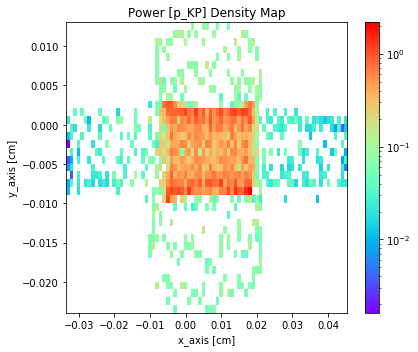

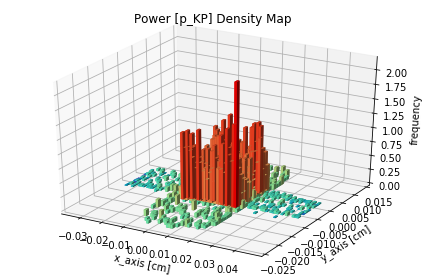

In [9]:
%%time
fig, ax = plt.subplots(figsize=(6, 5)) # Set some arbitrary figure size.
h_2     = h2(x_in, y_in, bins=[np.arange(x_in.min(),x_in.max(),dl),
                           np.arange(y_in.min(),y_in.max(),dl)], weights=weighting,
                           axis_names=["x_axis [cm]", "y_axis [cm]"], name="Power [p_KP] Density Map",aspect=1)

# Plot a 2-D histogram using x_in, y_in, and dl for binning. 
h_2.plot("image", cmap="rainbow", ax=ax, cmap_normalize="log")
# Plot shows image, normalized by a logarithmic scale.
h_2.plot("bar3d", cmap="rainbow", cmap_normalize="log");

In [10]:
# we have access to the intensity at each bin space:
h_2.frequencies.shape

(79, 37)

In [11]:
np.sum(h_2.frequencies,axis=1).shape

(79,)

In [12]:
h_2.numpy_bins[0][:-1].shape

(79,)

In [13]:
sum(h_2.frequencies.T).shape

(79,)

### X-direction split

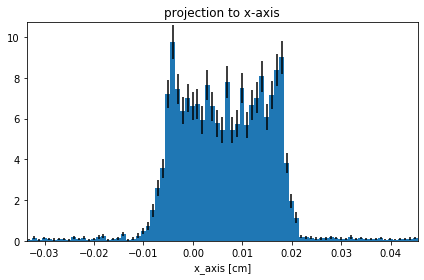

In [14]:
xproj = h_2.projection("x_axis [cm]", name="projection to x-axis")
xproj.plot(errors=True);

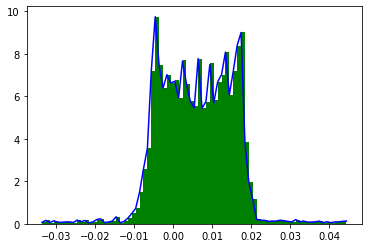

In [15]:
# These match the physt projection exactly...
plt.plot(h_2.numpy_bins[0][:-1],sum(h_2.frequencies.T),'b');

n, bins, patches = plt.hist(x_in,bins=h_2.numpy_bins[0][:-1],color='g',weights=weighting,density=False);
# Except for density argument, it consistently modifies the amplitude of our results.

# weights=np.ones(len(data)) / len(data), density=False, allows for normalization if needed.

In [16]:
mult = np.sum(n*np.diff(bins)) # Density=True has done what it said it would.
# When density=False, we obtain a factor which can change any "density=True" representation back.

In [17]:
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins = len(h_2.numpy_bins[0][:-1])
ind = np.linspace(x_in.min()-m*dl,x_in.max()+m*dl,nbins)
gkde = kde.gaussian_kde(x_in,weights=weighting)
gkde.set_bandwidth(0.05)

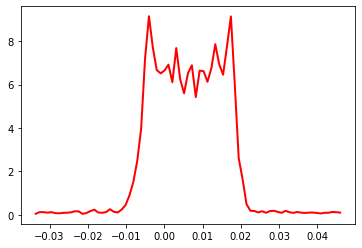

In [18]:
kdepdf         = gkde.evaluate(ind)
plt.plot(ind, kdepdf*mult,label='kde',color="r",linewidth=2);

### Y-direction split

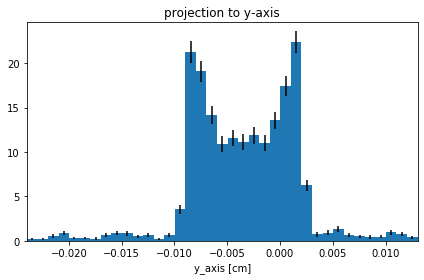

In [19]:
yproj = h_2.projection("y_axis [cm]", name="projection to y-axis")
yproj.plot(errors=True);

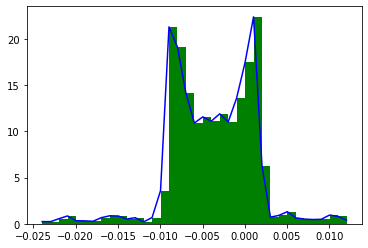

In [20]:
# These match the physt projection exactly...
plt.plot(h_2.numpy_bins[1][:-1],sum(h_2.frequencies),'b');
n, bins, patches = plt.hist(y_in,bins=h_2.numpy_bins[1][:-1],color='g',weights=weighting,density=False);
# Except for density argument, it consistently modifies the amplitude of our results.

In [21]:
mult = np.sum(n*np.diff(bins)) # Density=True has done what it said it would.
# When density=False, we obtain a factor which can change any "density=True" representation back.

In [22]:
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins = len(h_2.numpy_bins[1][:-1])
ind = np.linspace(y_in.min()-m*dl,y_in.max()+m*dl,nbins)
gkde = kde.gaussian_kde(y_in,weights=weighting)
gkde.set_bandwidth(0.05)

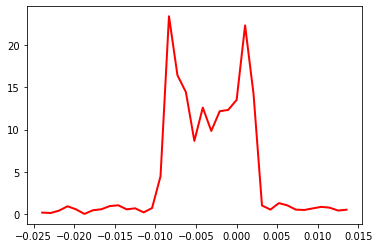

In [23]:
kdepdf = gkde.evaluate(ind)
plt.plot(ind, kdepdf*mult,label='kde',color="r",linewidth=2)

## Slice of Beam Shape

In [24]:
# These two quantities are relevant to our graphs in the cells below:
print(np.arange(np.amin(x_in)-m*dl,np.amax(x_in)+m*dl,dl)[:-1].shape)
print(sum(h_2.frequencies.T[:]).shape)

(79,)
(79,)


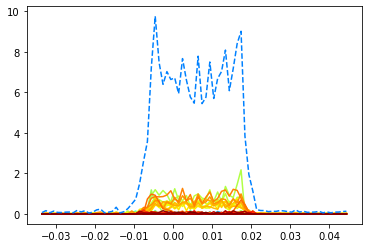

In [25]:
f=1
# Iterates through each possible resolved slice of beam across the X-direction.
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0.25, 1, len(h_2.frequencies.T)))))
for i in range(len(h_2.frequencies.T)):
    plt.plot(np.arange(np.amin(x_in)-m*dl,np.amax(x_in)+m*dl,dl)[:-1],sum(h_2.frequencies.T[i:f]),'-');
    f += 1
    
# This single plot (blue) represents the histogram sum of all possible beam slices in the X-direction.
plt.plot(np.arange(np.amin(x_in)-m*dl,np.amax(x_in)+m*dl,dl)[:-1],
         sum(h_2.frequencies.T[:len(h_2.frequencies.T)]),'--');

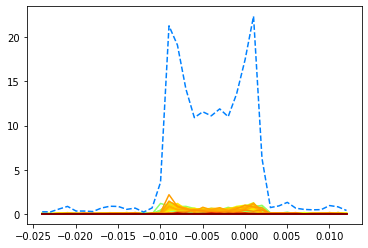

In [26]:
f=1
# Iterates through each possible resolved slice of beam across the Y-direction.
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0.25, 1, len(h_2.frequencies)))))
for i in range(len(h_2.frequencies)):
    plt.plot(np.arange(np.amin(y_in)-m*dl,np.amax(y_in)+m*dl,dl)[:-1],sum(h_2.frequencies[i:f]),'-');
    f += 1
    
# This single plot (blue) represents the histogram sum of all possible beam slices in the Y-direction.
plt.plot(np.arange(np.amin(y_in)-m*dl,np.amax(y_in)+m*dl,dl)[:-1],
         sum(h_2.frequencies[:len(h_2.frequencies)]),'--');

## 2D/3D Gaussian Representation

![alt text](methods.png "KDE Packages")

#### Currently using the <u>Scipy KDE package.</u>

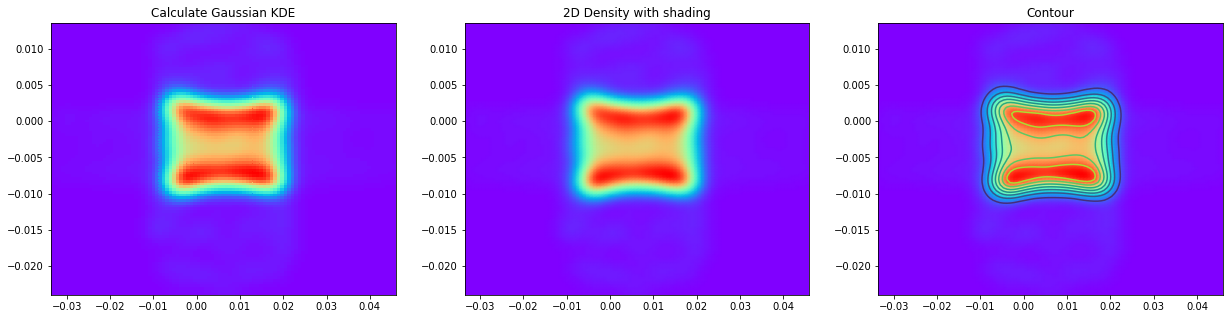

In [27]:
# Create a figure with 3 plot areas
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(21, 5))
 
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins     = 100
k         = kde.gaussian_kde([x_in,y_in], bw_method='scott', weights=weighting)
xi, yi    = np.mgrid[x_in.min():x_in.max():nbins*1j, y_in.min():y_in.max():nbins*1j]
zi        = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# plot a density
axes[0].set_title('Calculate Gaussian KDE')
axes[0].pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.rainbow)
 
# add shading
axes[1].set_title('2D Density with shading')
axes[1].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.rainbow)
 
# contour
axes[2].set_title('Contour')
axes[2].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.rainbow)
axes[2].contour(xi, yi, zi.reshape(xi.shape))

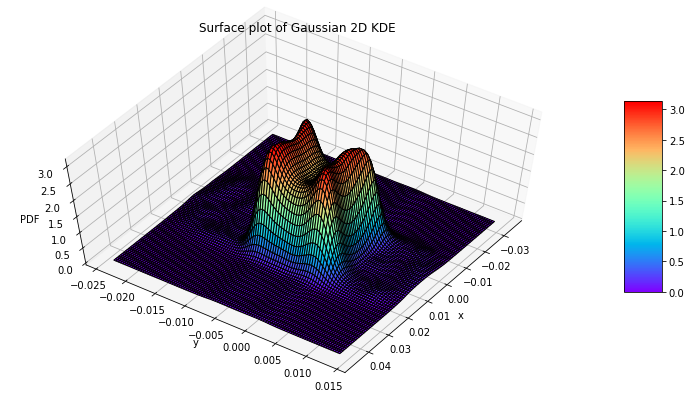

In [28]:
fig  = plt.figure(figsize=(13, 7))
ax   = plt.axes(projection='3d')
surf = ax.plot_surface(xi, yi, zi.reshape(xi.shape)*1e-3, rstride=1, cstride=1, cmap='rainbow', edgecolor='k')
# Y-axis not meaningful yet?

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('PDF')
ax.set_title('Surface plot of Gaussian 2D KDE')

fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF
ax.view_init(60, 35)